In [1]:
import voxel3d as v3d
import plane_fitting as pf
import numpy as np
import pandas as pd
import importlib
importlib.reload(v3d)
importlib.reload(pf)

<module 'plane_fitting' from '/Users/matdou/Documents/Rough-Terrain-Planning/plane_fitting.py'>

In [2]:
# The following paths require the "testing data" to be at the same level as the script
prefix = '2022-07-22_flight__0254_1658494839082804823'
lidar_dir = 'goose_3d_val/lidar/val/2022-07-22_flight'
labels_dir = 'goose_3d_val/labels/val/2022-07-22_flight'
csv_file = 'goose_3d_val/goose_label_mapping.csv'
flight_unique_ids = [
    '0071_1658494234334310308',
    '0072_1658494235988100385',
    '0073_1658494238675704025',
    '0075_1658494242083534022',
    '0077_1658494244047191404',
    '0078_1658494246011438339',
    '0080_1658494248904312093',
    '0082_1658494251900354294',
]

prefixes = ['2022-07-22_flight__' + id for id in flight_unique_ids]

In [3]:
# Initialize lists to store all point clouds, labels, and metadata
all_pointclouds = []
all_lidar_labels = []
all_label_metadata = []

# Iterate through the prefixes and load each point cloud
for prefix in prefixes:
    lidar_data, lidar_labels, label_metadata = pf.load_pointcloud_and_labels(prefix, lidar_dir, labels_dir, csv_file)
    
    # Append the loaded data to the lists
    all_pointclouds.append(lidar_data)
    all_lidar_labels.append(lidar_labels)
    all_label_metadata.append(label_metadata)


In [4]:
df = pd.read_csv('goose_3d_val/goose_label_mapping.csv')
label_to_class = dict(zip(df['label_key'], df['class_name']))

In [5]:
all_voxel_labels = []
all_voxel_maps = []
all_unique_voxel_labels = []

for i in range(len(all_pointclouds)):
    pointcloud = all_pointclouds[i]
    labels = all_lidar_labels[i]
    voxel_labels, voxel_map, unique_voxel_labels = v3d.voxelize_point_cloud_2d(pointcloud, voxel_size=1)
    all_voxel_labels.append(voxel_labels)
    all_voxel_maps.append(voxel_map)
    all_unique_voxel_labels.append(unique_voxel_labels)


In [6]:
all_map_to_majority = []
all_voxel_pointclouds = []
all_voxel_ids_after_preprocessing = []

for i in range(len(all_pointclouds)):
    voxel_labels = all_voxel_labels[i]
    pointcloud = all_pointclouds[i]
    labels = all_lidar_labels[i]
    map_to_majority, voxel_pointclouds, voxel_ids_after_preprocessing = pf.preprocess_voxels(
        voxel_labels=voxel_labels,
        pointcloud=pointcloud,
        labels=labels,
        min_len=10,
        proportion_threshold=0.7
    )
    all_map_to_majority.append(map_to_majority)
    all_voxel_pointclouds.append(voxel_pointclouds)
    all_voxel_ids_after_preprocessing.append(voxel_ids_after_preprocessing)


In [7]:
all_freq_df = []
for i in range(len(all_pointclouds)):
    map_to_majority = all_map_to_majority[i]
    freq_df = pf.analyze_label_frequency(map_to_majority, label_to_class, sort_order='ascending')
    all_freq_df.append(freq_df)

# Print the frequency table
pf.print_label_frequency(freq_df)


Label_key, Class_name, Frequency
4 obstacle 5
8 ego_vehicle 2
17 bush 690
23 asphalt 668
27 tree_crown 13
31 soil 63
38 building 385
41 fence 139
50 low_grass 91
51 high_grass 1068
59 hedge 619
131129 Unknown 6
262202 Unknown 3
327738 Unknown 6
393222 Unknown 1
655405 Unknown 1
720941 Unknown 1
917549 Unknown 1
1835066 Unknown 1


In [9]:
# Define the whitelist of class names to retain
whitelist = {'asphalt', 'low_grass', 'high_grass', 'hedge'}

all_voxel_ids = []
all_labels_wl = []

for i in range(len(all_pointclouds)):
    map_to_majority = all_map_to_majority[i]
    filtered_voxel_ids, labels_wl = pf.filter_voxels_by_whitelist(
        map_to_majority=map_to_majority,
        label_to_class=label_to_class,
        whitelist=whitelist
    )
    all_voxel_ids.append(filtered_voxel_ids)
    all_labels_wl.append(labels_wl)
    


INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 2483
INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 2821
INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 3246
INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 2653
INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 2351
INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 2216
INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 2363
INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 2446


In [10]:
all_plane_params = []

for i in range(len(all_pointclouds)):
    filtered_voxel_ids = all_voxel_ids[i]
    voxel_pointclouds = all_voxel_pointclouds[i]
    plane_params = pf.run_plane_fitting_on_voxels(
        filtered_voxel_ids=filtered_voxel_ids,
        voxel_pointclouds=voxel_pointclouds
    )
    all_plane_params.append(plane_params)

-----

In [11]:
all_rmse_map = []
for i in range(len(all_pointclouds)):
    plane_params = all_plane_params[i]
    map_to_majority = all_map_to_majority[i]
    rmse_map = pf.aggregate_rmse_by_label(
        plane_params=plane_params,
        map_to_majority=map_to_majority
    )
    all_rmse_map.append(rmse_map)

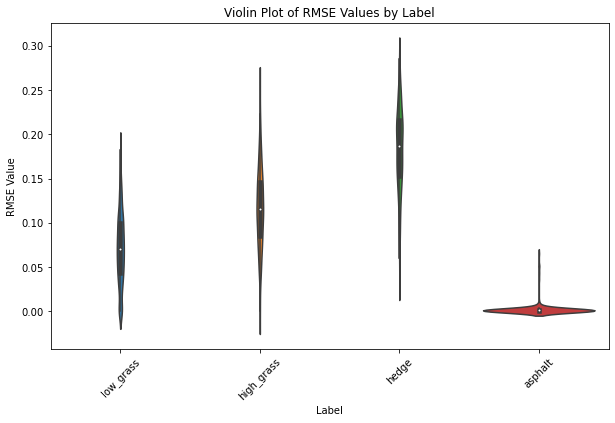

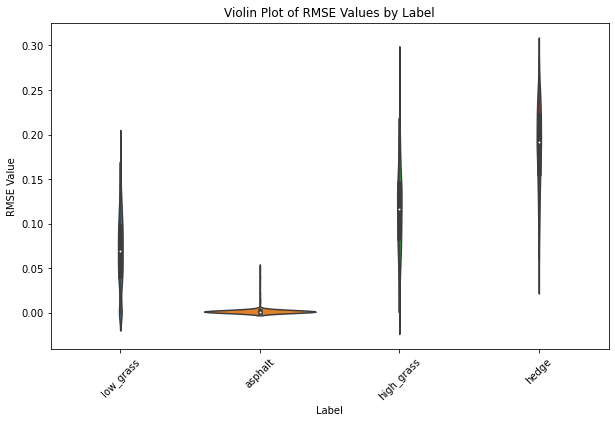

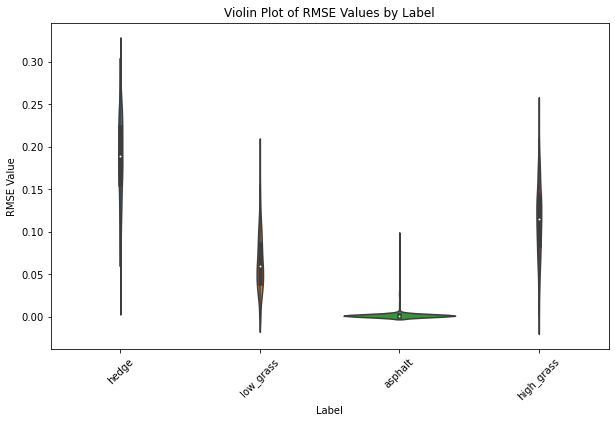

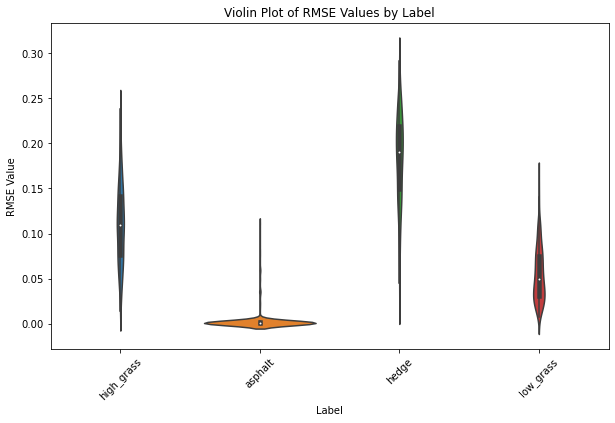

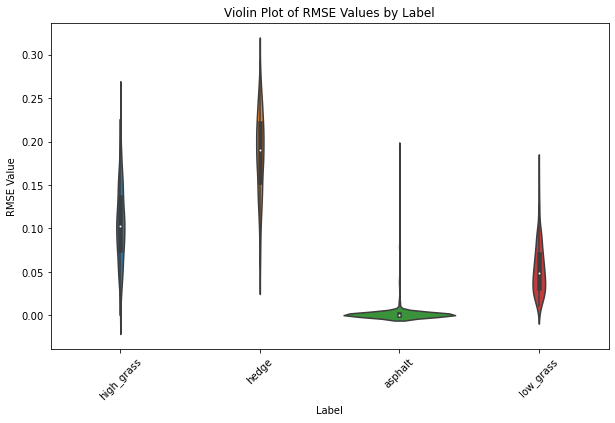

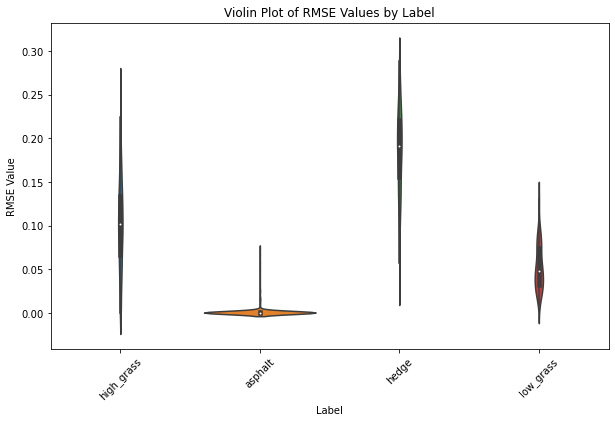

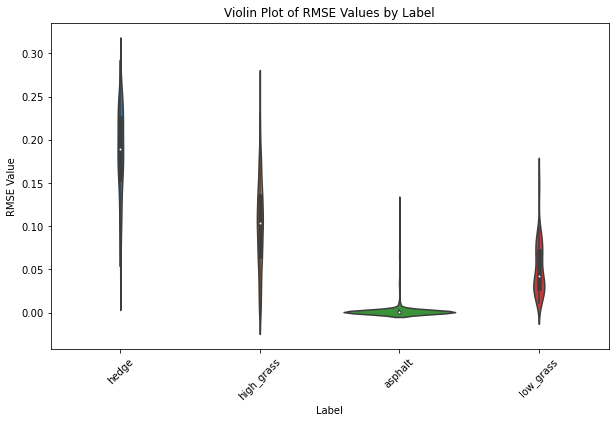

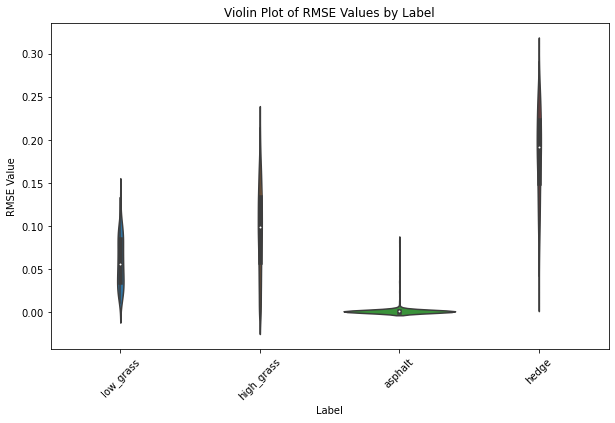

"pf.plot_rmse_violin(\n    rmse_map=rmse_map,\n    label_to_class=label_to_class,\n    figsize=(10, 6),\n    title='Violin Plot of RMSE Values by Label'\n)"

In [12]:
for i in range(len(all_pointclouds)):
    rmse_map = all_rmse_map[i]
    pf.plot_rmse_violin(
        rmse_map=rmse_map,
        label_to_class=label_to_class,
        figsize=(10, 6),
        title='Violin Plot of RMSE Values by Label'
    )
# Plot the violin plot for RMSE values by label
'''pf.plot_rmse_violin(
    rmse_map=rmse_map,
    label_to_class=label_to_class,
    figsize=(10, 6),
    title='Violin Plot of RMSE Values by Label'
)'''


In [13]:
#class to label
whitelist_list = list(whitelist)
class_to_label = {v: k for k, v in label_to_class.items()}
labels = [class_to_label[c] for c in whitelist_list]
labels

[50, 51, 23, 59]

In [14]:
# number of point clouds
n = len(all_rmse_map)
print(f"Number of point clouds: {n}")

#train test split
n_train = int(n * 0.8)
print(f"Number of training point clouds: {n_train}")


Number of point clouds: 8
Number of training point clouds: 6


In [15]:
def extract_features_and_targets(labels, pointcloud_rmse_range):
    features = []
    targets = []
    
    for label in labels: 
        for pointcloud_rmse in pointcloud_rmse_range:
            rmse_values = pointcloud_rmse[label]
            features += rmse_values
            targets += [label] * len(rmse_values)
    
    return np.array(features), np.array(targets)

n_train

X_train, y_train = extract_features_and_targets(labels, all_rmse_map[:n_train])
X_test, y_test = extract_features_and_targets(labels, all_rmse_map[n_train:])

# Convert into 2D arrays
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

print(f"X_train shape: {X_train.shape}")    
print(f"y_train shape: {y_train.shape}")    
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (15770, 1)
y_train shape: (15770,)
X_test shape: (4809, 1)
y_test shape: (4809,)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.4f}")


Classification Accuracy: 0.6342


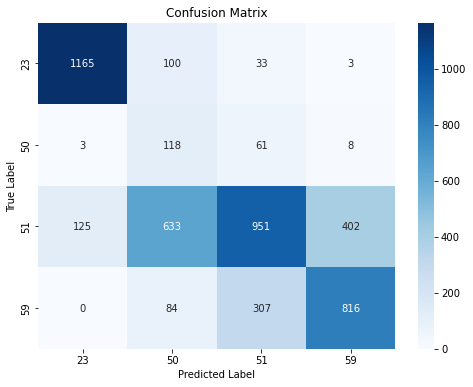

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [54]:
print([i for i in zip(whitelist_list, labels)])

[('low_grass', 50), ('high_grass', 51), ('asphalt', 23), ('hedge', 59)]


In [18]:
from sklearn.metrics import r2_score

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score (Linear Regression): {r2:.4f}")



R² Score (Linear Regression): 0.7291


In [19]:
# Check the size of X_test and y_test
print(f"Number of test samples: {len(X_test)}")


Number of test samples: 4809


In [20]:
all_voxel_pointclouds[0].keys()
all_map_to_majority[0].keys()

dict_keys([37, 46, 47, 51, 52, 62, 63, 64, 77, 79, 87, 93, 104, 105, 111, 112, 119, 121, 122, 123, 126, 127, 128, 129, 130, 138, 139, 140, 141, 142, 143, 144, 145, 146, 152, 153, 154, 155, 156, 157, 168, 169, 170, 171, 181, 183, 184, 185, 197, 198, 199, 208, 209, 210, 216, 217, 226, 239, 240, 258, 259, 266, 267, 274, 283, 302, 320, 334, 379, 380, 383, 384, 392, 405, 414, 422, 455, 468, 469, 482, 495, 513, 516, 517, 521, 528, 529, 537, 538, 554, 556, 557, 558, 564, 568, 575, 576, 589, 591, 593, 594, 595, 605, 613, 614, 627, 628, 629, 648, 649, 650, 656, 657, 658, 659, 660, 661, 662, 672, 673, 678, 679, 686, 687, 688, 700, 704, 705, 706, 713, 730, 731, 736, 737, 752, 755, 756, 757, 758, 775, 778, 779, 780, 781, 791, 795, 796, 800, 817, 826, 843, 854, 855, 862, 874, 885, 921, 934, 935, 953, 954, 956, 971, 972, 974, 980, 986, 987, 988, 999, 1000, 1001, 1003, 1006, 1007, 1008, 1009, 1018, 1019, 1021, 1027, 1028, 1041, 1042, 1049, 1050, 1066, 1079, 1081, 1084, 1085, 1097, 1110, 1111, 1128, 1

In [46]:
n = len(all_pointclouds)
n_train = int(n * 0.8)
X_train = []
Y_train = []
X_test = []
Y_test = []


for i in range(len(all_pointclouds)):
    
    for voxel_id, pointcloud in all_voxel_pointclouds[i].items():
        if all_map_to_majority[i][voxel_id] not in labels:
            continue
        if i < n_train:
            X_train.append(pointcloud)
            Y_train.append(all_map_to_majority[i][voxel_id])
        else:
            X_test.append(pointcloud)
            Y_test.append(all_map_to_majority[i][voxel_id])

X_test = np.array(X_test)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


/var/folders/m4/2f5s5kt17t356vc959c3jdsr0000gn/T/ipykernel_96677/2842331663.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test)
/var/folders/m4/2f5s5kt17t356vc959c3jdsr0000gn/T/ipykernel_96677/2842331663.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)


In [47]:
print(f"Shapes of X_train and Y_train: {X_train.shape}, {Y_train.shape}")
print(f"Shapes of X_test and Y_test: {X_test.shape}, {Y_test.shape}")

Shapes of X_train and Y_train: (15770,), (15770,)
Shapes of X_test and Y_test: (4809,), (4809,)


In [48]:
print(f"In the training set, the labels and their counts are as follows:")
for label, count in zip(*np.unique(Y_train, return_counts=True)):
    print(f"{label_to_class[label]}: {count / len(Y_train) * 100:.2f}%")
    
print(f"\nIn the test set, the labels and their counts are as follows:")
for label, count in zip(*np.unique(Y_test, return_counts=True)):
    print(f"{label_to_class[label]}: {count / len(Y_test) * 100:.2f}%")

In the training set, the labels and their counts are as follows:
asphalt: 20.10%
low_grass: 21.58%
high_grass: 32.49%
hedge: 25.83%

In the test set, the labels and their counts are as follows:
asphalt: 27.05%
low_grass: 3.95%
high_grass: 43.90%
hedge: 25.10%


In [49]:
import pickle

# Save X (features) and y (targets) as separate pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('Y_train.pkl', 'wb') as f:
    pickle.dump(Y_train, f)

with open('Y_test.pkl', 'wb') as f:
    pickle.dump(Y_test, f)
